In [8]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
from tqdm import tqdm
import cv2
import wandb

In [9]:
# wandb.login()
# run = wandb.init(
#     project='cancer-classifier-CNN-model-DL-course',
#     config={}
#     )

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from cancer_classifier.config import MODELS_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR, CLASSES
from cancer_classifier.processing.image_utils import adjust_image_contrast, resize_image_tensor, normalize_image_tensor, augment_image_tensor, process_dataset, save_processed_images, crop_image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing

### data crop and contract equilazing

In [11]:
for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(RAW_DATA_DIR, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        img = crop_image(img_path)
        # img = adjust_image_contrast(img)

        # save in processed directory
        cv2.imwrite(os.path.join(PROCESSED_DATA_DIR, cls, img_name), img)
        # save_processed_images(img_tensor, os.path.join(PROCESSED_DATA_DIR, cls), img_name)

In [12]:
img_size = (256, 256)
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

### data augmentation

In [13]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

### data spliting 

In [14]:
rand_gen = torch.Generator().manual_seed(142)
train_dataset, val_dataset, test_dataset = tdata.random_split(
    dataset = dataset,
    lengths=[train_ratio, val_ratio, test_ratio],
    generator=rand_gen
)

train_loader = tdata.DataLoader(
    dataset=train_dataset,
    batch_size=batch_nbr,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = tdata.DataLoader(
    dataset=val_dataset,
    batch_size=batch_nbr,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = tdata.DataLoader(
    dataset=test_dataset,
    batch_size=batch_nbr,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
def get_class_distribution(dataset):
    class_distribution = {}
    for _, label in dataset:
        if label.__str__() not in class_distribution:
            class_distribution[label.__str__()] = 0
        class_distribution[label.__str__()] += 1
    return class_distribution

print("Train dataset class distribution:", get_class_distribution(train_dataset))
print("Validation dataset class distribution:", get_class_distribution(val_dataset))
print("Test dataset class distribution:", get_class_distribution(test_dataset))

Train dataset class distribution: {'2': 1640, '1': 1601, '0': 1604}
Validation dataset class distribution: {'1': 211, '2': 209, '0': 186}
Test dataset class distribution: {'0': 214, '2': 199, '1': 192}


# Model Architecture: CNN

In [15]:
def conv_block(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1, pool_kernel_size=2,
                pool_stride=2, dropout_prob=0.2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout_prob),
        nn.MaxPool2d(pool_kernel_size, pool_stride)
    )

In [16]:
class CNNModel(nn.Module):
  def __init__(self, num_classes=3):
    super(CNNModel, self).__init__()

    self.conv_block1 = conv_block(1, 64, 3)
    self.conv_block2 = conv_block(64, 128, 5)
    self.conv_block3 = conv_block(128, 256, 5)
    self.conv_block4 = conv_block(256, 512, 3, 2)

    dummy_input = torch.randn(1, 1, 256, 256) # Sadece bir görsel için çıkış boyutu hesaplar
    dummy_output = self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(dummy_input))))

    flattened_size = torch.flatten(dummy_output, 1).size(1)

    print(f'the full architecture parameters size: {flattened_size}')

    self.fc_layers = nn.Sequential(
           nn.Dropout(0.3),
           nn.Linear(flattened_size, 512), # Hesaplanan boyutu kullan
           nn.ReLU(inplace=True),
           nn.Linear(512, num_classes)
        )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)

    x = torch.flatten(x, 1)

    x = self.fc_layers(x)

    return x


In [17]:
CNN_model = CNNModel(num_classes=len(CLASSES)).to(device)
# print(CNN_model)

the full architecture parameters size: 25088


## Training the model

### defining Loss function, Optimization method, and training parameters

In [18]:
loss_fn = nn.CrossEntropyLoss()
weights_decay = 0.0001
learning_rate = 0.0001
epochs = 5

# optimizer = torch.optim.Adam(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #->70%

optimizer = torch.optim.AdamW(
    CNN_model.parameters(),
    lr=learning_rate,
    weight_decay=weights_decay
) #->77.4

# optimizer = torch.optim.SGD(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #> 77.5

In [19]:
def test_loop(dataloader, model, loss_fn, epoch=0):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_labels = []
    pred_labels = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # wandb.log({"epoch": epoch,"accuracy": f"{(100*correct):>0.1f}", "test_loss": test_loss})

    return true_labels, pred_labels, correct, test_loss

In [20]:
from cancer_classifier.modeling.train import train
# import evaluate from cancer_classifier.modeling.evaluate as evaluate
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device) 
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_nbr + len(X)
            # wandb.log({"step":  f"{current:>5d}/{size:>5d}", "train_loss": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            

for epoch in tqdm(range(epochs)):
    print("----------------- EPOCH " + str(epoch) + "------------------")
    train_loop(
        dataloader=train_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epoch=epoch
        )
    true_labels, pred_labels, correct, test_loss =  test_loop(
        dataloader=test_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        epoch=epoch
    )


  0%|          | 0/5 [00:00<?, ?it/s]

----------------- EPOCH 0------------------
loss: 1.111723  [   16/ 4845]
loss: 0.692425  [ 1616/ 4845]
loss: 0.792875  [ 3216/ 4845]
loss: 0.601153  [ 4816/ 4845]



 20%|██        | 1/5 [00:18<01:14, 18.65s/it]

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.563210 

----------------- EPOCH 1------------------
loss: 0.743080  [   16/ 4845]
loss: 0.683598  [ 1616/ 4845]
loss: 0.514575  [ 3216/ 4845]
loss: 0.517130  [ 4816/ 4845]



 40%|████      | 2/5 [00:36<00:54, 18.11s/it]

Test Error: 
 Accuracy: 81.7%, Avg loss: 0.464069 

----------------- EPOCH 2------------------
loss: 0.583166  [   16/ 4845]
loss: 0.411832  [ 1616/ 4845]
loss: 0.617802  [ 3216/ 4845]
loss: 0.568545  [ 4816/ 4845]



 60%|██████    | 3/5 [00:54<00:35, 17.98s/it]

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.420455 

----------------- EPOCH 3------------------
loss: 0.396156  [   16/ 4845]
loss: 0.577954  [ 1616/ 4845]
loss: 0.616326  [ 3216/ 4845]
loss: 0.366725  [ 4816/ 4845]



 80%|████████  | 4/5 [01:12<00:17, 17.95s/it]

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.376347 

----------------- EPOCH 4------------------
loss: 0.273406  [   16/ 4845]
loss: 0.865580  [ 1616/ 4845]
loss: 0.248368  [ 3216/ 4845]
loss: 0.507083  [ 4816/ 4845]


100%|██████████| 5/5 [01:30<00:00, 18.01s/it]

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.308286 



In [21]:
true_labels, pred_labels, correct, test_loss =  test_loop(
    dataloader=test_loader,
    model=CNN_model,
    loss_fn=loss_fn
)

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.333334 



## Evaluating the model

### Covariance Matrix

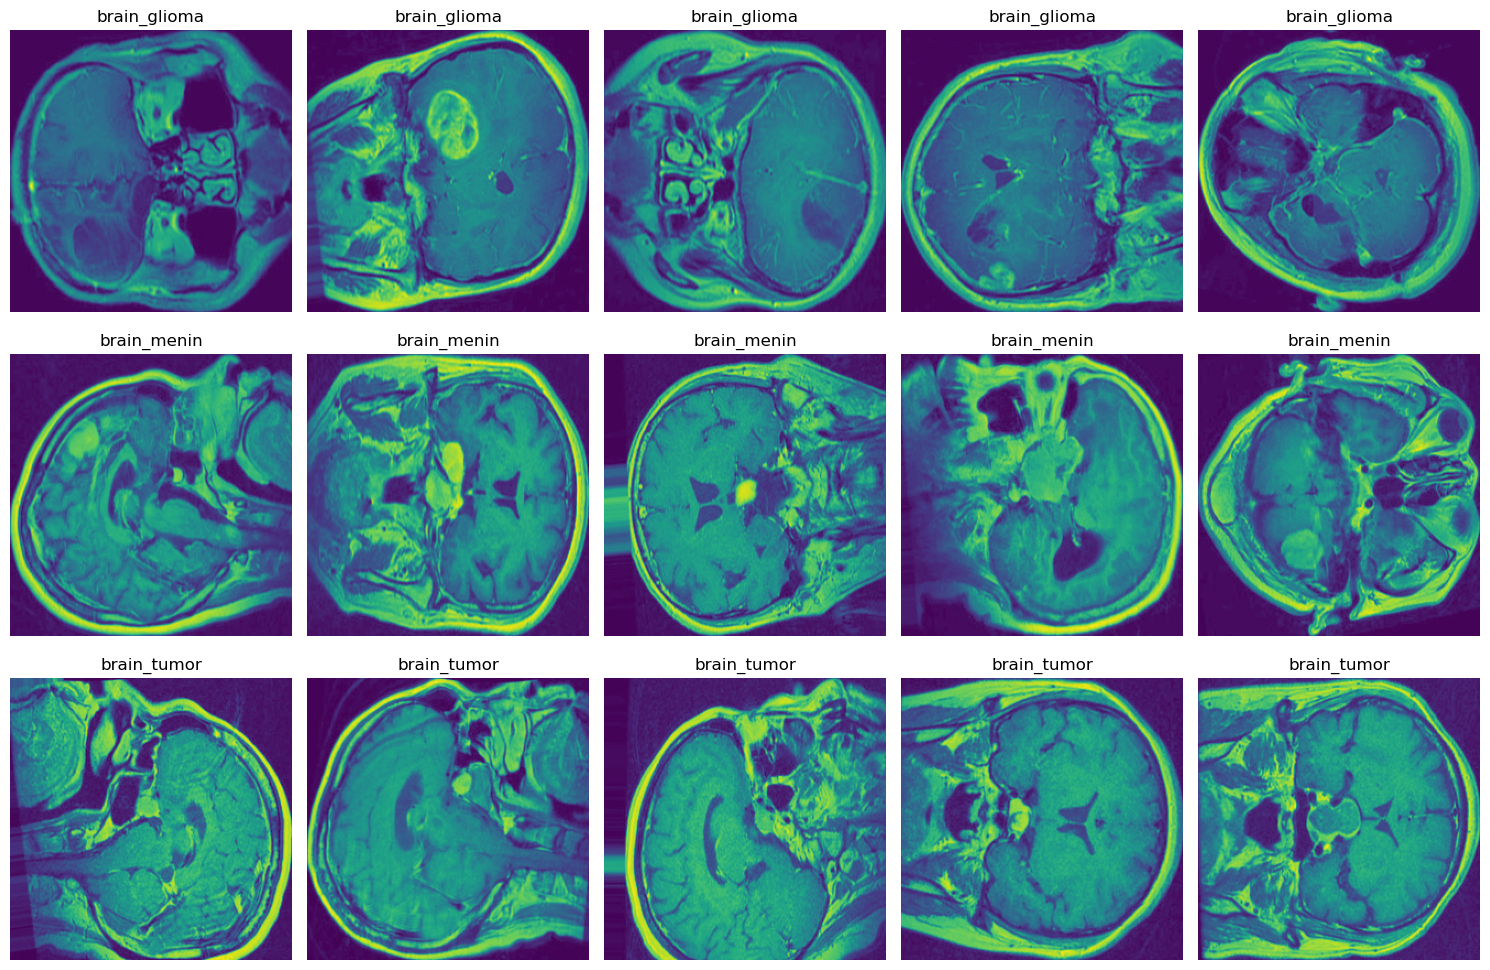

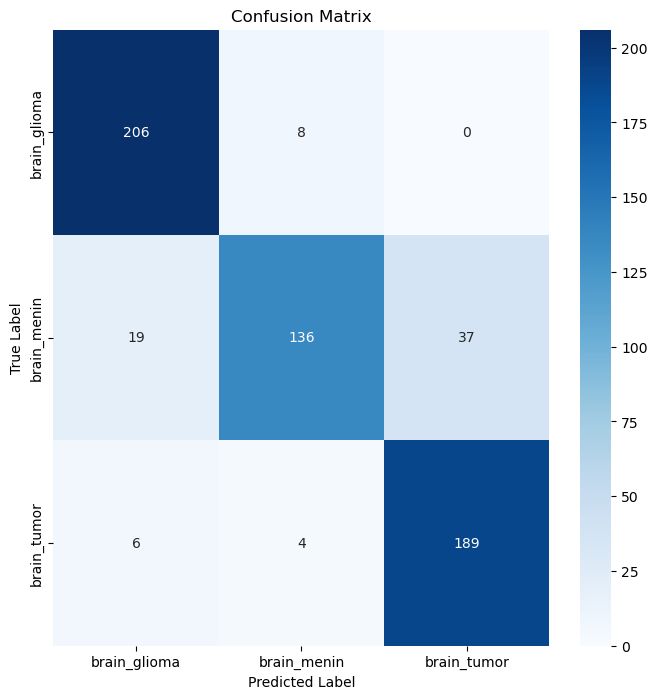

In [25]:
from cancer_classifier.plots import visualize_sample_images,  plot_confusion_matrix
import time

visualize_sample_images(
    dataset=dataset,
)
plot_confusion_matrix(
    true_classes=true_labels,
    predicted_classes=pred_labels,
    model_name =  time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model_cropped_image" + f"{(100*correct):>0.1f}%"
)

### serializing the model

In [24]:
import time
model_name = f"{(100*correct):>0.1f}%--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model_corped_images.pth"
torch.save(CNN_model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

Saved PyTorch Model State to 87.8%--2025-05-16_19-16-32_CNN_model_corped_images.pth
